**author**: lukethompson@gmail.com<br>
**date**: 20 Dec 2017<br>
**language**: Python 3.5<br>
**license**: BSD3<br>

## trading_cards_2_macros_figures.ipynb

Generate LaTeX macros and figures for a 'trading card' for any given Deblur OTU (sOTU or tag sequence).

### Settings and input files

In [1]:
import pandas as pd
import numpy as np
import biom
import wikipedia
import re
import os
import errno
import math
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# seaborn plot settings
sns.set(style='white', palette='colorblind', color_codes=True)
sns.set_context('talk', rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14})
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
# input
path_map = '/Users/luke.thompson/agp/manuscript-package-20170512/1250/ag_map_with_alpha_lrt.txt'
path_biom = '/Users/luke.thompson/agp/manuscript-package-20170512/1250/deblur_125nt_no_blooms_rare.biom'
path_otus = 'deblur_125nt_no_blooms_rare.seq_summary.tsv'
path_pls_bal = '/Users/luke.thompson/Dropbox/UCSD/AGP/submission-files-science-20170815/table_s11.xlsx'
trim_length = 125
rarefaction_depth = 1250
wiki_max_length = 450
trends_standard = 'Bacillus'

# output
path_output = 'latex'

In [4]:
dict_label = {'age_years': 'Age (years)',
              'latitude': 'Latitude (degrees)',
              'longitude': 'Longitude (degrees)',
              'prepared_meals_frequency': 'Prepared meals frequency',
              'age_cat': 'Age category',
              'antibiotic_history': 'Antibiotic history',
              'fruit_frequency': 'Fruit frequency',
              'types_of_plants': 'Types of plants'}

In [5]:
dict_title = {'age_years': 'Age',
              'latitude': 'Latitude',
              'longitude': 'Longitude',
              'age_cat': 'Age category',
              'antibiotic_history': 'Antibiotic history',
              'fruit_frequency': 'Fruit frequency',
              'prepared_meals_frequency': 'Prepared meals frequency',
              'types_of_plants': 'Types of plants'}

In [6]:
dict_order = {
    'age_cat': ['Baby', 'Child', 'Teen', '20s', '30s', '40s', '50s', '60s', '70+', 'Unspecified'],
    'antibiotic_history': ['Not within past year', 'Within past year', 'Within past 6 months',
                           'Within past month', 'Within past week', 'Unspecified'],
    'fruit_frequency': ['Daily', 'Regularly (3-5 times/week)', 'Occasionally (1-2 times/week)', 
                        'Rarely (less than once/week)', 'Never', 'Unspecified'],
    'prepared_meals_frequency': ['Daily', 'Regularly (3-5 times/week)', 'Occasionally (1-2 times/week)', 
                        'Rarely (less than once/week)', 'Never', 'Unspecified'],
    'types_of_plants': ['More than 30', '21 to 30', '11 to 20', '6 to 10', 'Less than 5', 'Unspecified']
}

### Functions

In [7]:
def make_directory(path):
    """Make directory if doesn't already exist"""
    try:
        os.mkdir(path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise exc
        pass

In [8]:
def get_wikipedia(my_taxonomy):
    """Get wikipedia entry for genus or higher (lowest taxonomic level that begins (position 3) 
    with capital letter)
    """
    for level in reversed(my_taxonomy.split('; ')):
        if len(level) > 3:
            if level[3].isupper():
                title = level[3:]
                print(title)
                try:
                    entry = wikipedia.page(title)
                    summary = entry.summary
                    return('%s\t%s' % (title, summary))
                except wikipedia.exceptions.DisambiguationError as e:
                    return('%s\t%s has multiple options: %s' % (title, title, e.options))
                except wikipedia.exceptions.PageError as e:
                    return('%s\t%s has no Wikipedia page.' % (title, title))
                break

In [9]:
def popularity(keywords, ax=None):
    """
    Parameters
    ----------
    keywords: list of str
        List of keywords to search for
    ax: Axes
        Matplotlib Axes object where the plot should be drawn.

    Returns
    -------
    axes
        Matplotlib axes object.
    """
    search = TrendReq(hl='en-US', tz=360)
    search.build_payload(keywords, cat=0, timeframe='today 5-y', geo='',
                         gprop='')

    df = search.interest_over_time()
    
    ax = df.plot(ax=ax, figsize=(6, 2.5))
    sns.despine(left=True)
    ax.set_ylabel('Popularity over time\n(Google Trends)')
    ax.set_xlabel('Date')
    plt.legend(bbox_to_anchor=(1,1))
    ax.autoscale(enable=True, axis='x', tight=True)

    return ax

In [10]:
def scatter_map(table, samples, seq):
    """Make dataframe of a given otu with metadata"""
    otu_count = table.data(id=seq, axis='observation')
    df_otu = pd.DataFrame(data=otu_count, index=samples, columns=['otu'])
    df_otu_map = pd.merge(df_map, df_otu, left_index=True, right_index=True)
    # must remove zero counts otherwise scatter plot is misleading
    df_otu_map.otu = [np.nan if x==0 else x for x in df_otu_map.otu]
    return(df_otu_map)

In [11]:
def drop_non_numeric(s):
    try:
        s1 = float(s)
        return s1
    except ValueError:
        return np.nan

### Section 1: Read input tables

In [12]:
# read mapping file
df_map = pd.read_csv(path_map, sep='\t', index_col=0, low_memory=False)
# read otu summary
df_otus = pd.read_csv(path_otus, sep='\t', index_col=0)
# read biom table
table = biom.load_table(path_biom)
# biom table properties
otus = table.ids(axis='observation')
samples = table.ids(axis='sample')
num_samples = samples.shape[0]

In [13]:
# pls balances from paper (new column for absolute value of PLS1)
df_pls_farmer = pd.read_excel(path_pls_bal, sheetname='Remote farmer')
df_pls_farmer['PLS1_abs'] = [abs(x) for x in df_pls_farmer['PLS1']]
df_pls_hunter = pd.read_excel(path_pls_bal, sheetname='Hunter gatherer')
df_pls_hunter['PLS1_abs'] = [abs(x) for x in df_pls_hunter['PLS1']]
df_pls_country = pd.read_excel(path_pls_bal, sheetname='Country')
df_pls_country['PLS1_abs'] = [abs(x) for x in df_pls_country['PLS1']]
df_pls_plants = pd.read_excel(path_pls_bal, sheetname='Plants')
df_pls_plants['PLS1_abs'] = [abs(x) for x in df_pls_plants['PLS1']]

### Section 2: Make the OTU lists

#### Top metadata categories ordered by unweighted effect size (largest to smallest)

In [14]:
top_cat = ['age_cat', 'center_project_name', 'antibiotic_history', 'processing_robot', 'prepared_meals_frequency', 
           'race', 'salted_snacks_frequency', 'sugary_sweets_frequency', 'country', 'longitude', 
           'fruit_frequency', 'collection_month', 'types_of_plants', 'latitude', 'fungal_overgrowth',
           'bowel_movement_frequency', 'drinks_per_session', 'vioscreen_caffeine', 'primer_plate', 'probiotic_frequency']

#### Option 1: Top OTUs by num_samples

In [15]:
df_otus_top_prev = df_otus.sort_values('num_samples', ascending=False).head(10)

In [16]:
df_otus_top_prev[['sequence', 'num_samples', 'num_samples_frac', 'num_samples_rank',
            'total_obs', 'total_obs_frac', 'total_obs_rank', 'taxonomy']].to_csv('deblur_125nt_no_blooms_rare.top10_prevalence.tsv')

#### Option 2: Top OTUs by total_obs

In [17]:
df_otus_top_abund = df_otus.sort_values('total_obs', ascending=False).head(10)

In [18]:
df_otus_top_abund[['sequence', 'num_samples', 'num_samples_frac', 'num_samples_rank',
       'total_obs', 'total_obs_frac', 'total_obs_rank', 'taxonomy']].to_csv('deblur_125nt_no_blooms_rare.top10_abundance.tsv')

#### Option 3: Manually pick OTUs

Here: 

* Most prevalent
* Most abundant
* S24-7 (most prevalent sequence of S24-7)

In [19]:
manual_seqs = list(df_otus[df_otus.num_samples_rank == 1]['sequence']) + list(
    df_otus[df_otus.total_obs_rank == 1]['sequence']) + [
    df_otus[['S24-7' in tax for tax in df_otus.taxonomy]].iloc[0, :]['sequence']]

In [20]:
df_otus_manual = df_otus[df_otus['sequence'].isin(manual_seqs)]

#### Option 4 Highest OTUs by PLS1 balance

* Note that some PLS1 sheets have 100bp sOTUs, not 150bp!
* First sort by absolute value and get top 10 for each.
* Then find any sequences with first 100bp (of 125bp) matching the 100bp of PLS1 entries.
* Finally, filter so sequences must be found in at least 100 samples.

In [21]:
pls_seqs_farmer = list(df_pls_farmer.sort_values(by='PLS1_abs', ascending=False).head(10)['sOTU'].values)
pls_seqs_hunter = list(df_pls_hunter.sort_values(by='PLS1_abs', ascending=False).head(10)['sOTU'].values)
pls_seqs_country = list(df_pls_country.sort_values(by='PLS1_abs', ascending=False).head(10)['sOTU'].values)
pls_seqs_plants = list(df_pls_plants.sort_values(by='PLS1_abs', ascending=False).head(10)['sOTU'].values)

In [22]:
pls_seqs = pls_seqs_farmer + pls_seqs_hunter + pls_seqs_country + pls_seqs_plants

In [23]:
df_otus_pls = df_otus[pd.Series([seq[:100] for seq in df_otus['sequence']]).isin(pls_seqs)]
df_otus_pls = df_otus_pls[df_otus_pls.num_samples >= 100]

#### Then store chosen dataframe as df_otus_top

In [24]:
df_otus_top = df_otus_pls

### Section 3. Make the trading cards

#### Look up Wikipedia information

In [25]:
# add wikipedia summary
df_otus_top.loc[:,'wikipedia'] = df_otus_top['taxonomy'].apply(get_wikipedia)
df_otus_top.loc[:,'title'] = [value.split('\t')[0] for value in df_otus_top['wikipedia']]
df_otus_top.loc[:,'wikipedia'] = [value.split('\t')[1] for value in df_otus_top['wikipedia']]

Prevotella
Lactobacillus
Prevotella
Succinivibrio


#### Point plot function

In [26]:
def make_point_plot(row, df, category, figpath, dict_title, dict_order):
    """Make pointplot given these inputs:
        row - occurrence information for one sequence (row in df_otus, imported from *.seq_summary.tsv)
        df - metadata dataframe
        category - metadata category
    """
    category_count_all = df[category].value_counts()
    category_count_sequence = df.loc[row['list_samples'].split(',')][category].value_counts()
    df_pointplot_data = pd.concat([category_count_all/category_count_all.sum(), 
                                   category_count_sequence/category_count_sequence.sum()], axis=1)
    df_pointplot_data.columns = ['count_all', 'count_sequence']
    df_pointplot_data[category] = df_pointplot_data.index
    df_pointplot_data_melted = pd.melt(df_pointplot_data, id_vars=[category],
                                       value_vars=['count_all', 'count_sequence'])
    
    fig, ax = plt.subplots(figsize=(2.5,3.5))
    sns.pointplot(x='variable', y='value', hue=category, hue_order=dict_order[category], data=df_pointplot_data_melted)
    plt.xlabel('')
    plt.xticks([0, 1], ('All\nsamples', 'Samples\ncontaining\nsequence'))
    plt.ylabel('Relative distribution')
    plt.box('off')
    sns.despine(offset=-20, bottom=True, trim=True)

    #plt.title(dict_title[category], fontsize=18)
    plt.legend(bbox_to_anchor=(1,1)) # title=category
    plt.savefig(figpath, bbox_inches='tight', transparent=True)

#### Make trading card latex macros and plots

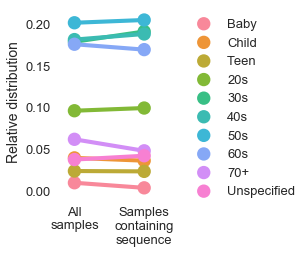

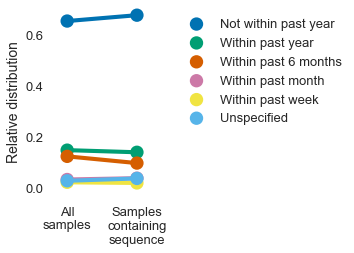

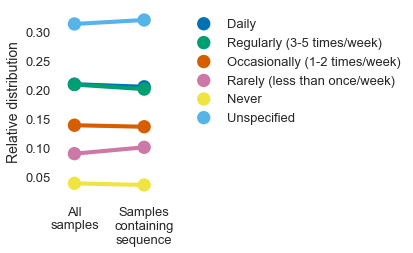

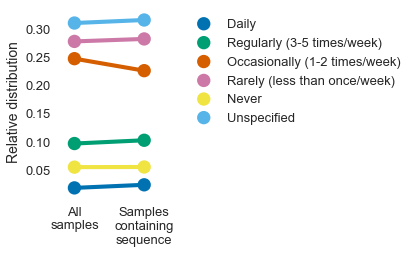

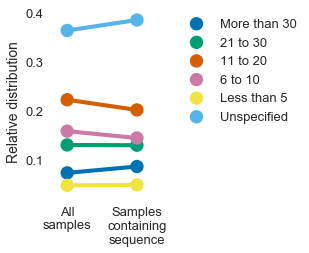

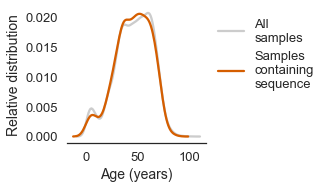

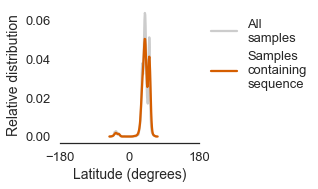

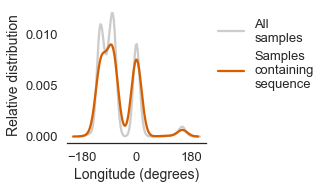

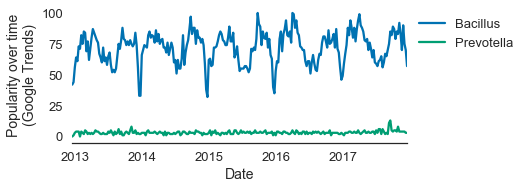

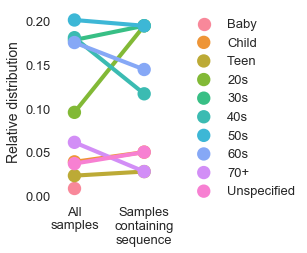

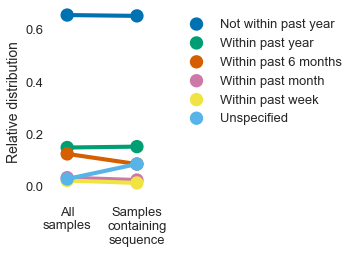

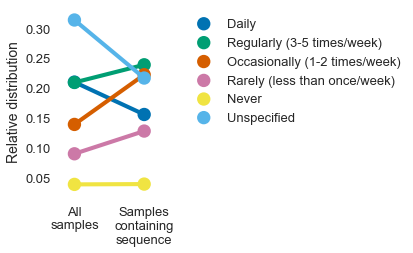

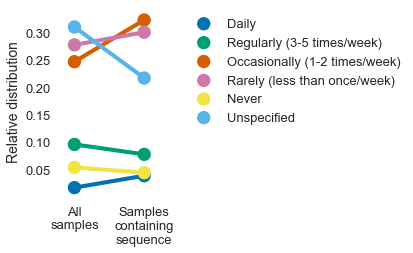

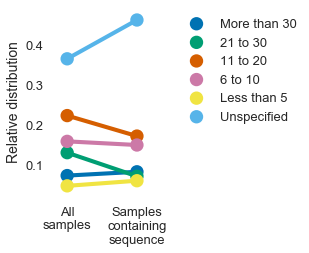

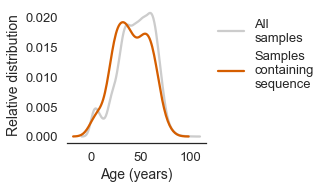

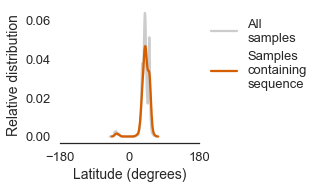

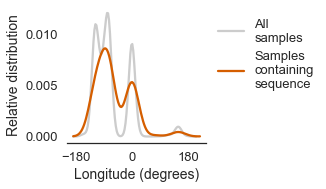

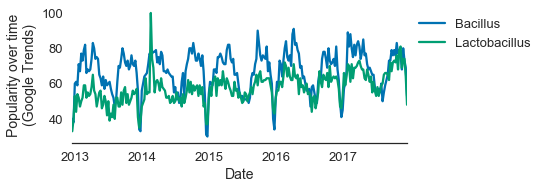

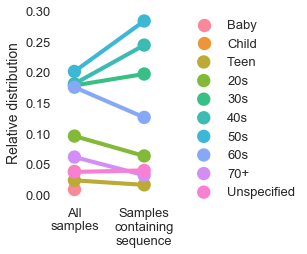

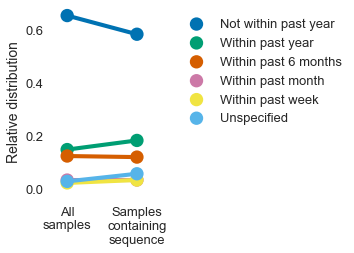

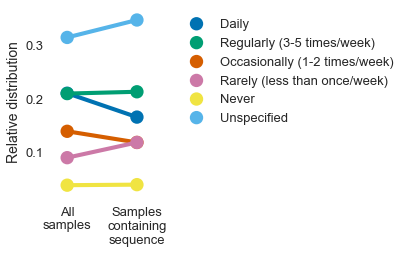

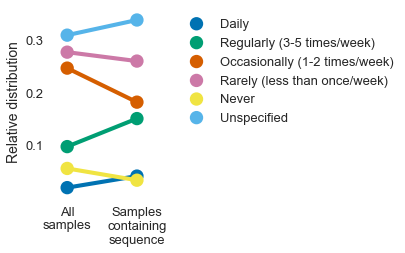

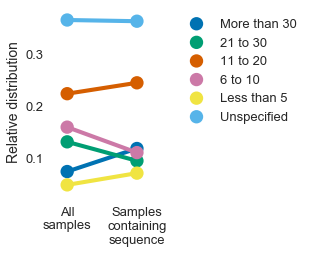

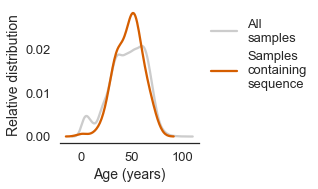

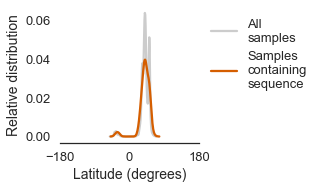

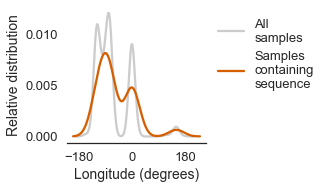

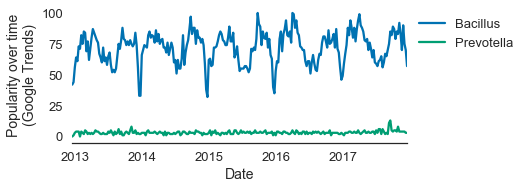

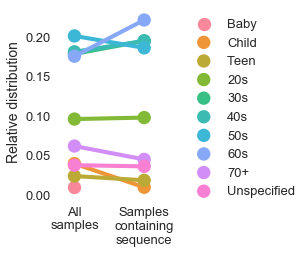

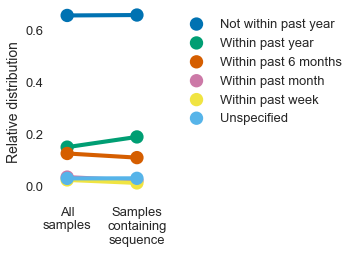

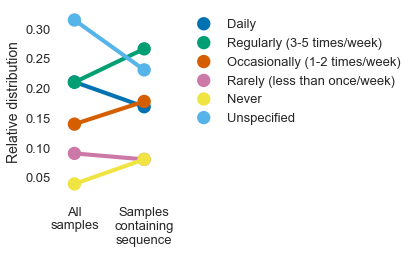

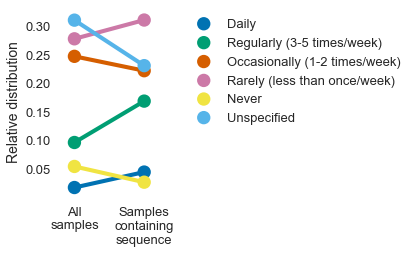

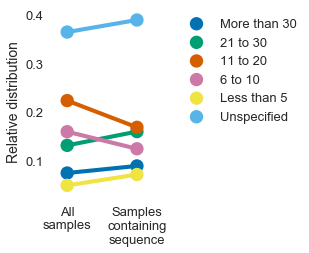

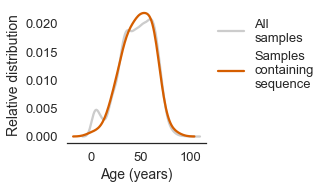

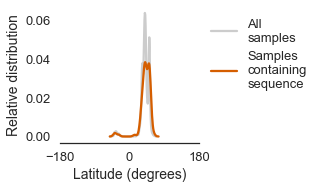

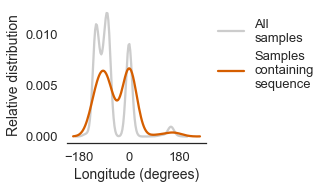

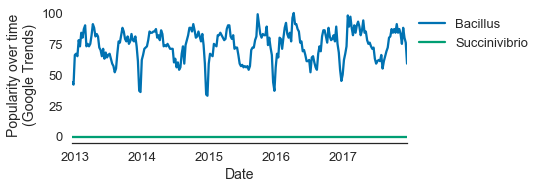

In [27]:
for index, row in df_otus_top.iterrows():
    
    # STORE THE RELEVANT VALUES
    sequence = row['sequence']
    taxonomy_gg = re.sub(r'_', r'\_', row['taxonomy'])
    wiki_entry = row['wikipedia']
    wiki_entry = re.sub(r' "', r' ``', wiki_entry) # order of quote replacement is important
    wiki_entry = re.sub(r" '", r' `', wiki_entry)
    wiki_entry = re.sub(r'"', r"''", wiki_entry)
    wiki_entry = re.sub(r'–', r'--', wiki_entry)
    wiki_entry = re.sub(r'%', r'\%', wiki_entry)
    wiki_entry = re.sub(r'\$', r'\\$', wiki_entry)
    wiki_entry = re.sub(u'\u201D', r"''", wiki_entry) # need to replace unicode backward double quote
    title = row['title']
    prevalencePercent = row['num_samples_frac'] * 100
    prevalenceRank = str(row['num_samples_rank'])
    abundancePercent = row['total_obs_frac'] * 100
    abundanceRank = str(row['total_obs_rank'])
    numOTUs = str(df_otus.shape[0])
    numSamples = str(num_samples)
    trimLength = str(trim_length)
    rarefactionDepth = str(rarefaction_depth)

    # MAKE DIRECTORY
    new_directory = '%s/card_%sbp_rare%s_rank%s_%s' % (path_output, 
            trimLength, rarefactionDepth, prevalenceRank, title)
    make_directory(new_directory)
    
    # CREATE MACROS FILE
    with open('%s/macros.tex' % new_directory, 'w') as target:
        # SEQUENCE
        target.write(r'\def\sequence{')
        # first 50bp
        target.write(sequence[:50])
        # next 50bp
        target.write('\n')
        target.write(sequence[50:100])
        # next 50bp if > 100bp
        if len(sequence) > 100:
            target.write('\n')
            target.write(sequence[100:150])
        target.write('}\n')
        # TAXONOMY
        target.write(r'\def\taxonomyGG{')
        target.write(taxonomy_gg)
        target.write('}\n')
        # WIKIPEDIA
        target.write(r'\def\wikipedia{')
        if len(wiki_entry) < wiki_max_length:
            target.write(wiki_entry)
        else:
            wiki_sentences = wiki_entry.split('. ')
            num_drop_sentences = -1
            while len('. '.join(wiki_sentences[:num_drop_sentences])) > wiki_max_length:
                num_drop_sentences = num_drop_sentences - 1
            target.write('. '.join(wiki_sentences[:num_drop_sentences]))
            target.write('.')
            if len('. '.join(wiki_sentences[:num_drop_sentences])) == 0:
                target.write(wiki_entry[:wiki_max_length])
                target.write('...')
        target.write('}\n')
        # PREVALENCE
        target.write(r'\def\prevalencePercent{')
        target.write('{:0.2f}'.format(prevalencePercent))
        target.write('}\n')
        target.write(r'\def\prevalenceRank{')
        target.write(prevalenceRank)
        target.write('}\n')
        # ABUNDANCE
        target.write(r'\def\abundancePercent{')
        target.write('{:0.4f}'.format(abundancePercent))
        target.write('}\n')
        target.write(r'\def\abundanceRank{')
        target.write(abundanceRank)
        target.write('}\n')
        # METHODS/MISC
        target.write(r'\def\numOTUs{')
        target.write(numOTUs)
        target.write('}\n')
        target.write(r'\def\trimLength{')
        target.write(trimLength)
        target.write('}\n')
        target.write(r'\def\numSamples{')
        target.write(numSamples)
        target.write('}\n')
        target.write(r'\def\rarefactionDepth{')
        target.write(rarefactionDepth)
        target.write('}\n')
        
    # POINT PLOT OF PRESENCE/ABSENCE
    for category in ['age_cat', 'antibiotic_history', 'fruit_frequency', 'prepared_meals_frequency', 'types_of_plants']: 

        figpath = '%s/point_%s.pdf' % (new_directory, category)
        make_point_plot(row, df_map, category, figpath, dict_title, dict_order)
        
    # KDE PLOT OF DISTRIBUTION
    for category in ['age_years', 'latitude', 'longitude']: 

        # get category values of 1- samples OTU is found in and 2- all samples
        cat_values = pd.Series([drop_non_numeric(i) for i in df_map.loc[row['list_samples'].split(',')][category]])
        cat_values.dropna(inplace=True)
        all_cat_values = pd.Series([drop_non_numeric(i) for i in df_map[category]])
        all_cat_values.dropna(inplace=True)
        # draw dist plots
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(2.5, 2.5))
        sns.despine(left=True)
        sns.distplot(all_cat_values, hist=False, rug=False, kde=True, color='0.8', label='All\nsamples')
        sns.distplot(cat_values, hist=False, rug=False, kde=True, color='r', label='Samples\ncontaining\nsequence')
        #plt.title(dict_title[category], fontsize=18)
        if (category == 'longitude') | (category == 'latitude'):
            plt.xticks([-180, 0, 180])
        plt.xlabel(dict_label[category])
        plt.ylabel('Relative distribution')
        plt.legend(bbox_to_anchor=(1,1)) # title=category
        figpath = '%s/kde_%s.pdf' % (new_directory, category)
        plt.savefig(figpath, bbox_inches='tight', transparent=True)
        
    # GOOGLE TRENDS
    popularity([trends_standard, title])
    figpath = '%s/trends.pdf' % (new_directory)
    plt.savefig(figpath, bbox_inches='tight', transparent=True)